In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/USML'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/USML

/content/drive/MyDrive/USML


In [4]:
# Importing necessarcy modules
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

In [5]:
# Normalize and pre-process the images
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess an image by applying a series of transformations.

    :param image_path: Path to the image file (str)
    :param target_size: Tuple representing the target size for resizing. Default is (224, 224) (tuple)

    Returns:
    - numpy.ndarray: Preprocessed image as a NumPy array.
    """
    img = Image.open(image_path)
    img = img.resize(target_size)

    img = np.array(img.convert('L'))  # Convert to grayscale using PIL

    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std  # Normalize using mean and standard deviation

    return img

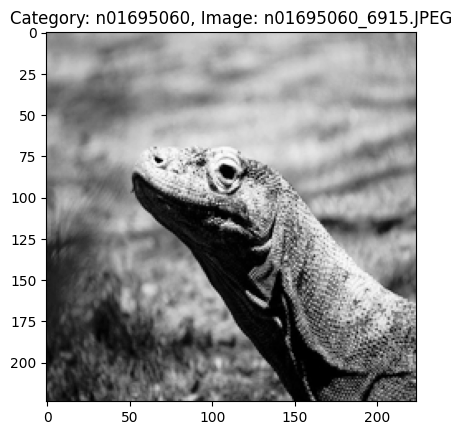

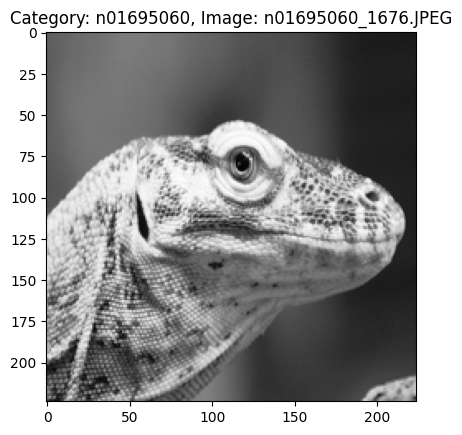

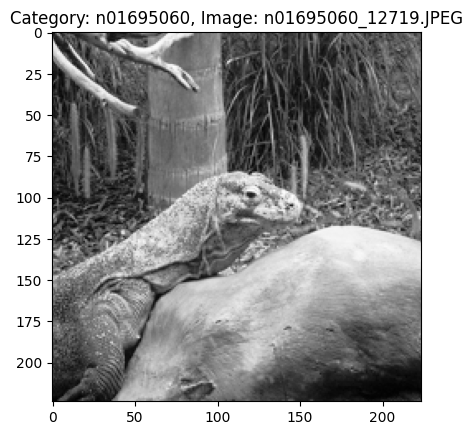

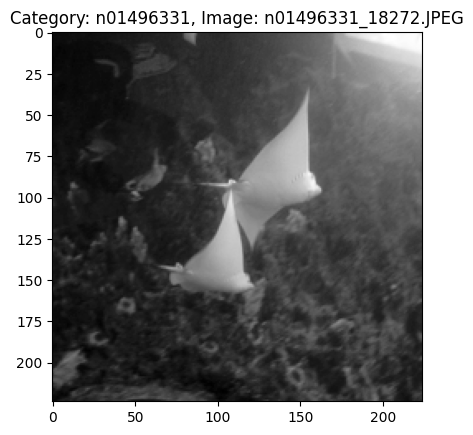

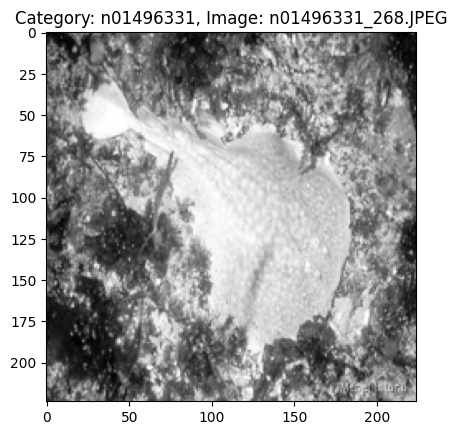

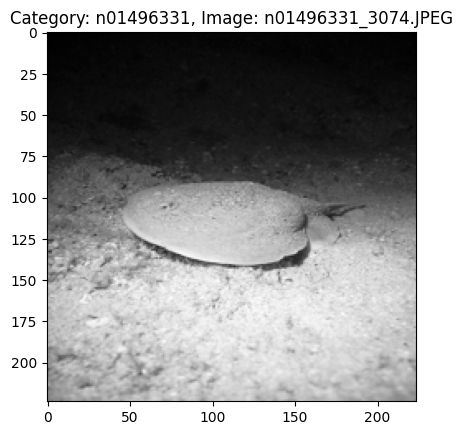

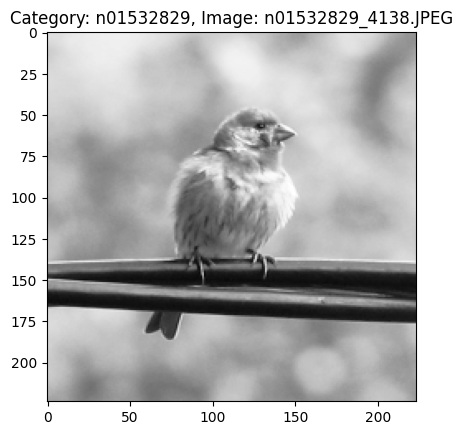

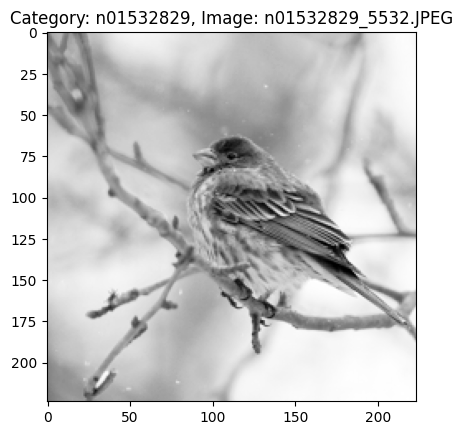

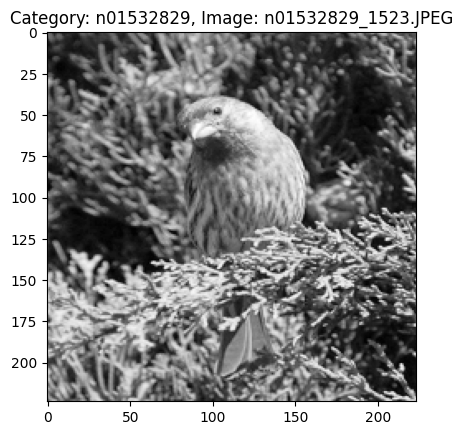

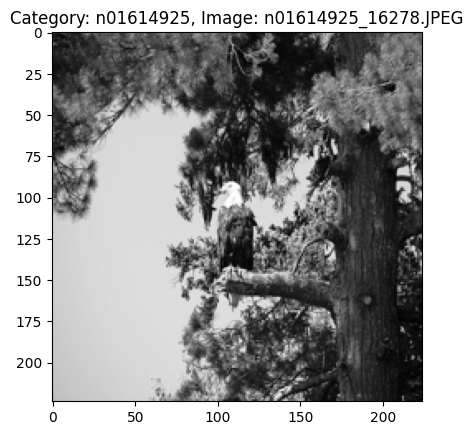

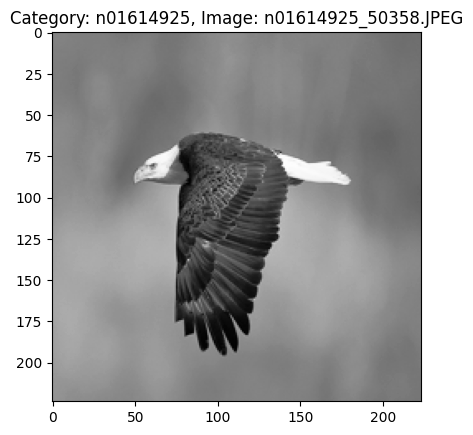

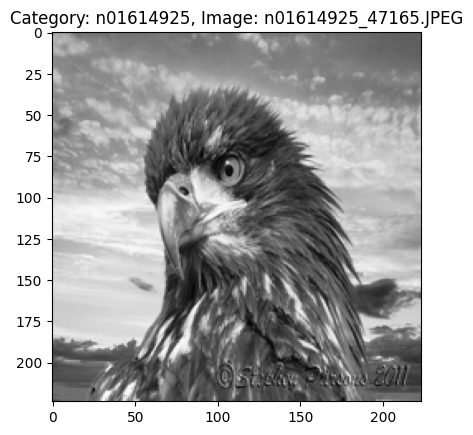

In [6]:
# View some of the sample images from the dataset
def display_sample_images(base_path, num_categories=4, images_per_category=3):
    """
    Display a sample of random preprocessed images from different categories in the dataset.

    :param base_path: Path to the dataset directory.
    :param num_categories: Number of categories to display.
    :param images_per_category: Number of images to display per category.
    """
    categories = os.listdir(base_path)
    random.shuffle(categories)

    for category in categories[:num_categories]:
        category_path = os.path.join(base_path, category)
        image_files = os.listdir(category_path)
        random.shuffle(image_files)

        for image_file in image_files[:images_per_category]:
            image_path = os.path.join(category_path, image_file)
            preprocessed_img = preprocess_image(image_path)

            # Display the preprocessed image
            plt.imshow(preprocessed_img, cmap=plt.cm.Greys_r)
            plt.title(f"Category: {category}, Image: {image_file}")
            plt.show()

# Path to imagenet-mini dataset
base_path = '/content/drive/MyDrive/USML/imagenet-mini/train/'

# Display preprocessed images
display_sample_images(base_path)

In [7]:
# Paths to training and testing datasets
train_base_path = '/content/drive/MyDrive/USML/imagenet-mini/train/'
test_base_path = '/content/drive/MyDrive/USML/imagenet-mini/val/'

In [8]:
# Collect preprocessed training images
train_images = []
for category in os.listdir(train_base_path):
    category_path = os.path.join(train_base_path, category)
    for image_file in os.listdir(category_path):
        image_path = os.path.join(category_path, image_file)
        preprocessed_img = preprocess_image(image_path)
        train_images.append(preprocessed_img)

# Convert the list of training images to a NumPy array
train_images = np.array(train_images)

train_images[0:5]

array([[[ 1.71477113e+00,  1.71477113e+00,  1.71477113e+00, ...,
          1.63029109e+00,  1.70069112e+00,  1.68661112e+00],
        [ 1.71477113e+00,  1.71477113e+00,  1.71477113e+00, ...,
          1.68661112e+00,  1.68661112e+00,  1.68661112e+00],
        [ 1.71477113e+00,  1.71477113e+00,  1.71477113e+00, ...,
          1.65845110e+00,  1.65845110e+00,  1.67253111e+00],
        ...,
        [-7.91469999e-01, -4.11309828e-01, -1.71949720e-01, ...,
          4.61650565e-01,  5.17970590e-01,  6.02450628e-01],
        [-6.78829948e-01, -1.86029727e-01, -1.15629695e-01, ...,
          6.02450628e-01,  1.94130444e-01,  7.29170685e-01],
        [-5.09869872e-01, -1.01549689e-01,  2.92690489e-01, ...,
          2.78610482e-01,  2.08210451e-01,  6.02450628e-01]],

       [[-1.36587642e+00, -1.26949477e+00, -1.14901772e+00, ...,
         -1.14901772e+00, -1.05263608e+00, -1.12492231e+00],
        [-1.17311313e+00, -1.17311313e+00, -1.02854067e+00, ...,
         -1.24539936e+00, -1.05263608e

In [9]:
# Collect preprocessed test images
test_images = []
for category in os.listdir(test_base_path):
    category_path = os.path.join(test_base_path, category)
    for image_file in os.listdir(category_path):
        image_path = os.path.join(category_path, image_file)
        preprocessed_img = preprocess_image(image_path)
        test_images.append(preprocessed_img)

# Convert the list of test images to a NumPy array
test_images = np.array(test_images)

In [10]:
def perform_hyperparameter_tuning(images, estimator, param_grid):
    """
    Performs hyperparameter tuning for a clustering algorithm using GridSearchCV.

    :param images: The input images as a NumPy array.
    :param estimator: The clustering algorithm (e.g., KMeans, DBSCAN, AgglomerativeClustering).
    :param param_grid: Dictionary specifying the hyperparameter grid for GridSearchCV.
    :return: Tuple containing the best hyperparameters and the best clustering model.
    """
    print("Tuning:", estimator)
    flattened_images = images.reshape(images.shape[0], -1)
    # Gridsearch CV on negative mean squared error
    grid_search = GridSearchCV(estimator, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(flattened_images)

    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_

    return best_params, best_estimator

In [11]:
# Define the hyperparameter grid
kmeans_param_grid = {'n_clusters': [3, 5, 7, 10], 'init': ['k-means++', 'random']}
spectral_param_grid = {'n_clusters': [3, 4, 5], 'gamma': [0.1, 1, 10], 'affinity': ['nearest_neighbors', 'rbf']}
hierarchical_param_grid = {'n_clusters': [3, 5, 7, 10], 'linkage': ['ward', 'complete', 'average'], 'affinity': ['euclidean', 'manhattan']}

# Perform hyperparameter tuning for K-Means on training images
best_kmeans_params, best_kmeans = perform_hyperparameter_tuning(train_images, KMeans(), kmeans_param_grid)
print(best_kmeans_params)

# Perform hyperparameter tuning for Spectral on training images
best_spectral_params, best_spectral = perform_hyperparameter_tuning(train_images, SpectralClustering(), spectral_param_grid)
print(best_spectral_params)

# Perform hyperparameter tuning for Hierarchical Clustering on training images
best_hierarchical_params, best_hierarchical = perform_hyperparameter_tuning(train_images, AgglomerativeClustering(), hierarchical_param_grid)
print(best_hierarchical_params)

Tuning: KMeans()
{'init': 'k-means++', 'n_clusters': 3}
Tuning: SpectralClustering()
{'affinity': 'nearest_neighbors', 'gamma': 0.1, 'n_clusters': 3}
Tuning: AgglomerativeClustering()
{'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 3}


In [13]:
# Apply the best clustering models on testing images
test_images_reshaped = test_images.reshape(test_images.shape[0], -1)
best_kmeans_labels_test = best_kmeans.predict(test_images_reshaped)
best_spectral_labels_test = best_spectral.fit_predict(test_images_reshaped)
best_hierarchical_labels_test = best_hierarchical.fit_predict(test_images_reshaped)

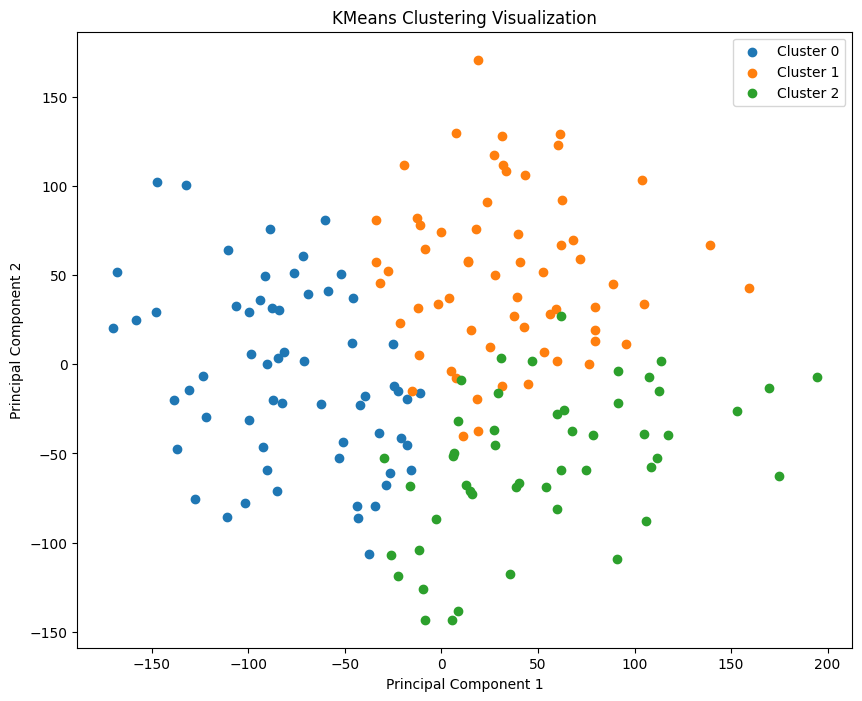

In [14]:
# Assuming best_kmeans_labels_test contains the cluster labels assigned by KMeans

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
test_images_pca = pca.fit_transform(test_images_reshaped)

# Scatterplot for KMeans clustering
plt.figure(figsize=(10, 8))

for cluster_num in range(best_kmeans.n_clusters):
    cluster_points = test_images_pca[best_kmeans_labels_test == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

plt.title('KMeans Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

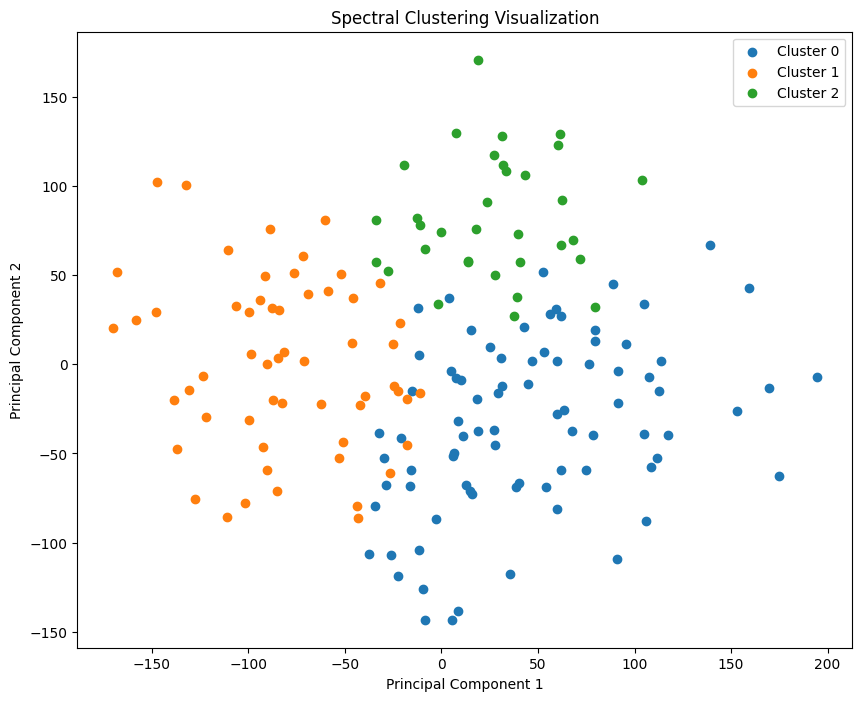

In [ ]:
# Scatter plot for Spectral clustering
plt.figure(figsize=(10, 8))

for cluster_num in range(best_spectral.n_clusters):
    cluster_points = test_images_pca[best_spectral_labels_test == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

plt.title('Spectral Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

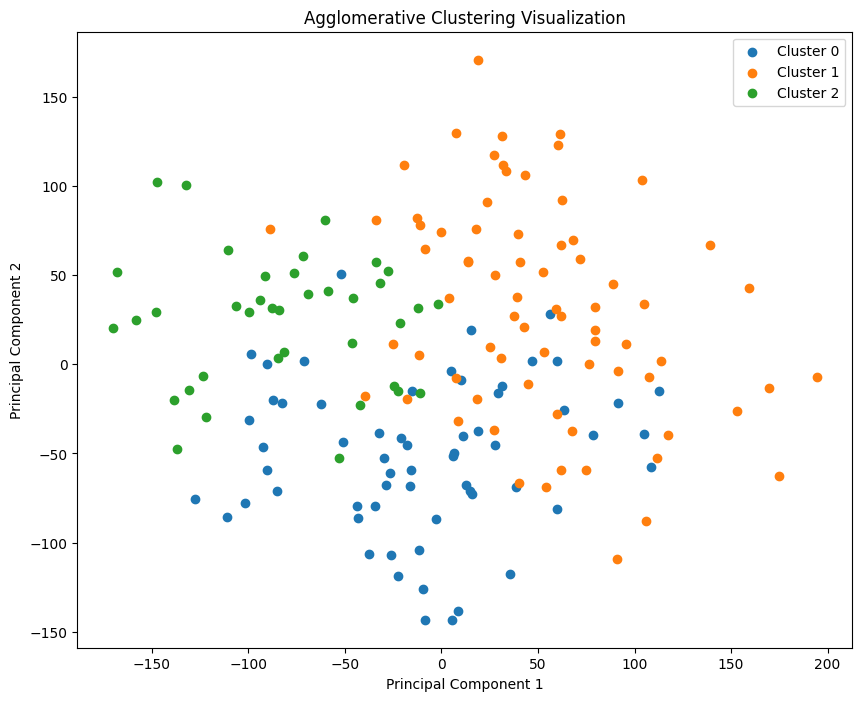

In [15]:
# Scatterplot for Agglomerative clusterting
plt.figure(figsize=(10, 8))

# Plot clusters
for cluster_num in np.unique(best_hierarchical_labels_test):
    cluster_points = test_images_pca[best_hierarchical_labels_test == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_num}')

plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [16]:
labels = [best_kmeans_labels_test, best_spectral_labels_test, best_hierarchical_labels_test]
model_names = ["KMeans Clustering", "Spectral Clustering", "Agglomerative Clustering"]

silhouette_scores=[]
davies_scores=[]
calinski_harabasz_scores=[]
for label, model in zip(labels, model_names):
  # Calculate Evaluation Metrics
  silhouette_avg = silhouette_score(test_images_reshaped, label)
  davies_bouldin = davies_bouldin_score(test_images_reshaped, label)
  calinski_harabasz = calinski_harabasz_score(test_images_reshaped, label)
  silhouette_scores.append(silhouette_avg)
  davies_scores.append(davies_bouldin)
  calinski_harabasz_scores.append(calinski_harabasz)


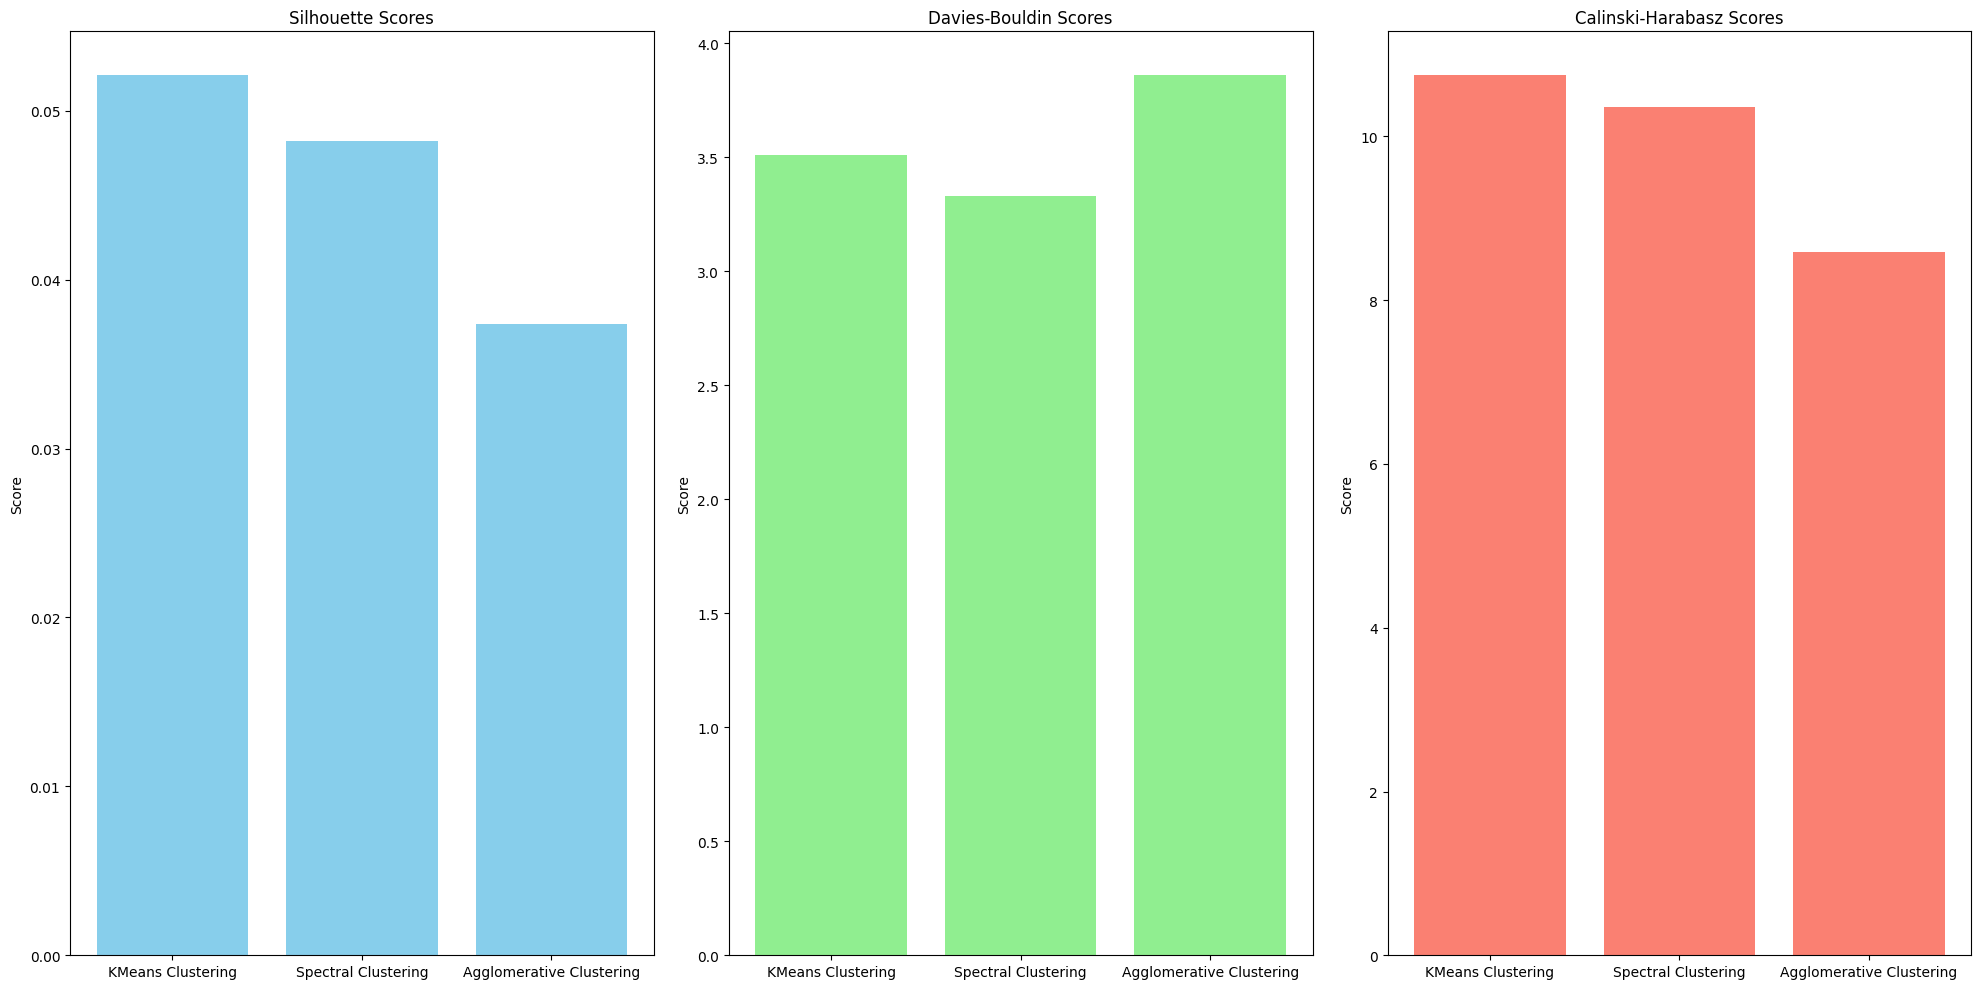

In [17]:
model_names = ["KMeans Clustering", "Spectral Clustering", "Agglomerative Clustering"]
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Silhouette Score Plot
ax[0].bar(model_names, silhouette_scores, color='skyblue')
ax[0].set_title('Silhouette Scores')
ax[0].set_ylabel('Score')

# Davies-Bouldin Score Plot
ax[1].bar(model_names, davies_scores, color='lightgreen')
ax[1].set_title('Davies-Bouldin Scores')
ax[1].set_ylabel('Score')


# Calinski-Harabasz Score Plot
ax[2].bar(model_names, calinski_harabasz_scores, color='salmon')
ax[2].set_title('Calinski-Harabasz Scores')
ax[2].set_ylabel('Score')


plt.tight_layout()
plt.show()


In [18]:
# Create train and test labels using K-means which is the best algorithm
train_labels = best_kmeans.fit_predict(train_images.reshape(train_images.shape[0], -1))
test_labels = best_kmeans.fit_predict(test_images.reshape(test_images.shape[0], -1))


In [22]:
#Train a random forest model using the labels created by K-means
rf = RandomForestClassifier(random_state=42,
    n_estimators=100,max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True )


X_train_reshaped = train_images.reshape(train_images.shape[0], -1)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train_reshaped, train_labels, cv=5)  # 5-fold cross-validation

# Print the mean and standard deviation of the scores
print(f"CV Mean: {np.mean(cv_scores):.2f}, CV Standard Deviation: {np.std(cv_scores):.2f}")

rf.fit(train_images.reshape(train_images.shape[0], -1), train_labels)
# Evaluate the best model on the test set
predicted_labels = rf.predict(test_images.reshape(test_images.shape[0], -1))
print(f"Accuracy: {accuracy_score(test_labels, predicted_labels)}")
print(classification_report(test_labels, predicted_labels))

CV Mean: 0.86, CV Standard Deviation: 0.03
Accuracy: 0.436046511627907
              precision    recall  f1-score   support

           0       0.73      0.88      0.80        52
           1       0.19      0.22      0.20        55
           2       0.37      0.26      0.31        65

    accuracy                           0.44       172
   macro avg       0.43      0.45      0.44       172
weighted avg       0.42      0.44      0.42       172



In [25]:
train_labels_replace=[]
predefined_labels = {
    'n01440764': 0,
    'n01443537': 0,
    'n01695060':2,
    'n01694178':2,
    'n01514859':1,
    'n01518878':1
}

for category in os.listdir(train_base_path):
    if category not in predefined_labels.keys():
      continue
    category_path = os.path.join(train_base_path, category)
    for image_file in os.listdir(category_path):
        image_path = os.path.join(category_path, image_file)
        train_labels_replace.append(predefined_labels[category])

# Convert the list3q2a of training images to a NumPy array
train_images_replace = np.array(train_labels_replace)


In [28]:
# Perform semi supervised learning by using and labelling 10% of train data
train_labels[0:70]=train_labels_replace[0:70]
train_labels[216:289]=train_labels_replace[70:143]
train_labels[1538:]=train_labels_replace[141:]

In [29]:
test_labels_replace=[]
predefined_labels = {
    'n01440764': 0,
    'n01443537': 0,
    'n01695060':2,
    'n01694178':2,
    'n01514859':1,
    'n01518878':1
}

for category in os.listdir(test_base_path):
    if category not in predefined_labels.keys():
      continue
    category_path = os.path.join(test_base_path, category)
    for image_file in os.listdir(category_path):
        image_path = os.path.join(category_path, image_file)
        test_labels_replace.append(predefined_labels[category])

# Convert the list of training images to a NumPy array
test_images_replace = np.array(test_labels_replace)


In [31]:
# Perform semi supervised learning by using and labelling 10% of test data
test_labels[0:6]=test_images_replace[0:6]
test_labels[21:28]=test_images_replace[6:13]
test_labels[166:]=test_images_replace[13:]

In [32]:
rf = RandomForestClassifier(random_state=42,
    n_estimators=100,max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True )


X_train_reshaped = train_images.reshape(train_images.shape[0], -1)

# Perform cross-validation
cv_scores = cross_val_score(rf, X_train_reshaped, train_labels, cv=5)  # 5-fold cross-validation

# Print the mean and standard deviation of the scores
print(f"CV Mean: {np.mean(cv_scores):.2f}, CV Standard Deviation: {np.std(cv_scores):.2f}")

#Train the random forest model
rf.fit(train_images.reshape(train_images.shape[0], -1), train_labels)

# Evaluate the best model on the test set
predicted_labels = rf.predict(test_images.reshape(test_images.shape[0], -1))
print(f"Accuracy: {accuracy_score(test_labels, predicted_labels)}")
print(classification_report(test_labels, predicted_labels))

CV Mean: 0.78, CV Standard Deviation: 0.08
Accuracy: 0.45348837209302323
              precision    recall  f1-score   support

           0       0.73      0.90      0.80        50
           1       0.21      0.21      0.21        56
           2       0.40      0.32      0.35        66

    accuracy                           0.45       172
   macro avg       0.44      0.48      0.46       172
weighted avg       0.43      0.45      0.44       172



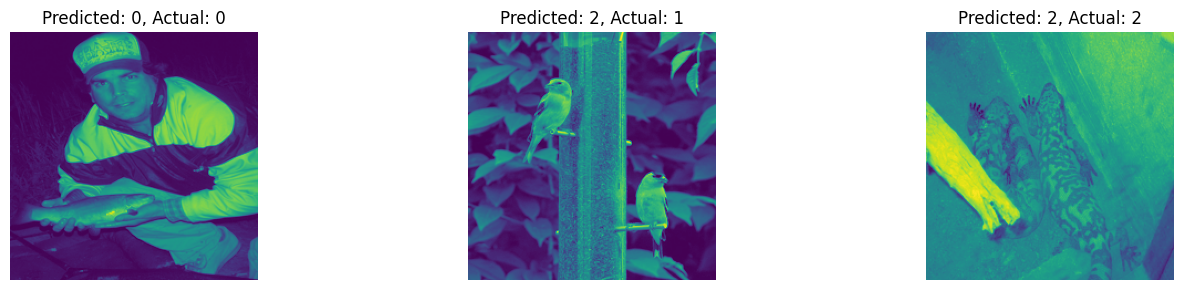

In [34]:
# Take a few examples and perform predictions using the random forest
indices=[2,38,156]
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

for i, index in enumerate(indices):
    test_image = test_images[index]
    test_label = test_labels[index]

    # Predict the label for the test image
    predicted_label = rf.predict(test_image.reshape(1, -1))[0]

    # Display the test image along with predicted and actual labels
    axes[i].imshow(test_image)
    axes[i].set_title(f"Predicted: {predicted_label}, Actual: {test_label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()
